In [1]:
import csv
import re
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
sys.path.append("..") # adds higher directory to python modules path

from LoaderPACK.Loader import load_whole_data, load_shuffle_5_min
import torch

# Section 1: Visualize the eeg-recording and targets

In the following a whole eeg-recording will be loaded:

In [2]:
device = "cpu"

# the load_whole_data laods a whole eeg-recording and targets into memory
trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", 
                            series_dict = 'train_series_length.pickle', 
                            ind = [i for i in range(1, 195 + 1)])

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)
it = iter(trainloader)
model_input, model_target, model_data = next(it)

torch.set_printoptions(edgeitems=2)

print(model_input[0])

print()

print(model_target[0])

print()

print(model_input[0].shape)

tensor([[ 0.0601, -3.4870,  ..., -0.6444, -0.1669],
        [-0.9249,  5.6028,  ..., -0.4507, -0.1218],
        [ 2.3317, -5.0536,  ...,  0.7382,  0.1175],
        [ 0.9897, -7.1149,  ...,  1.3465,  0.1151]])

tensor([[0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.]])

torch.Size([4, 290000])


Thus 4 channels from this individuals recording will be used in the training process.

The network will be trained on only 5 minutes of data. Thus the above recorded data is passed into another dataloader. This dataloader cuts the recording into 5 min. intervals:

In [3]:
device = "cpu"

# the load_whole_data laods a whole eeg-recording and targets into memory
trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", 
                            series_dict = 'train_series_length.pickle', 
                            ind = [i for i in range(1, 195 + 1)])

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)
it = iter(trainloader)

batch_size = 1

# the load_shuffle_5_min cuts the recording and targets loaded from load_whole_data
# into random 5 minutes intervals.
loader2 = load_shuffle_5_min(next(it), device)
loader2 = torch.utils.data.DataLoader(loader2,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=0)

it2 = iter(loader2)
model_input, model_target, model_data = next(it2)

torch.set_printoptions(edgeitems=2)

print(model_input[0][0])

print(model_target[0][0])

tensor([  4.8908,  -1.9910,  ..., -13.3886,   2.9354])
tensor([0., 0.,  ..., 0., 0.])


# Section 2: Equalize dataloading

The Lorenz curve will be used to visualize the equality of the data.

In [4]:
def lorenz_curve(ls: list, name: str):
    """
    This function return a lorenz curve for the lenght of the patients
    eeg recordings.

    Args:
        ls (list): list with the length of each eeg recording.
        name (str): the name - or sting displayed in the title of the 
                    plot.

    Return:
        matplotlib plot
    """
    
    tot_sum = sum(ls) # get the total sum of intervals
    nr_patients = len(ls) # get the number of patients
    sorted_ls = sorted(ls) # sort the list
    
    res = []
    rang = [i/100 for i in range(0, 100 + 5, 5)] # get the percentage range
    for per in rang:
        res.append(sum(sorted_ls[:math.floor(nr_patients * per)])/tot_sum)
    
    plt.title(f"Lorenz curve of {name}")
    plt.xlabel("Cummulative % of patients")
    plt.ylabel("Cummulative % of intervals")
    plt.plot(rang, res)
    plt.plot(rang, rang)
    return plt

For the train encoding file, each patient can be linked with his recordings:

In [5]:
path = "C:/Users/Marc/Desktop/model_data/train_model_data"

patient_samples = dict()

with open(path + '/train_encoding.csv', 'r') as file:
    ls = csv.reader(file)
    for rows in ls:
        m = re.match(r".+/\d+/(\d+)/+.", rows[0])
        val_to_dict = patient_samples.get(m.group(1), [])
        val_to_dict.append(rows[2])
        patient_samples[m.group(1)] = val_to_dict

In [6]:
print(patient_samples)

{'00000297': ['1'], '00000906': ['2', '3', '4'], '00001154': ['5'], '00001402': ['6'], '00002272': ['7'], '00002348': ['8', '9', '10'], '00002508': ['11'], '00002991': ['12'], '00003363': ['13'], '00003573': ['14'], '00004526': ['15', '16'], '00004586': ['17'], '00004625': ['18'], '00005230': ['19', '20'], '00005400': ['21'], '00005457': ['22'], '00005740': ['23', '24'], '00006052': ['25'], '00006091': ['26', '27'], '00006224': ['28'], '00006319': ['29'], '00006440': ['30', '31', '32', '33', '34'], '00006510': ['35'], '00006531': ['36', '37', '38', '39'], '00006535': ['40', '41', '42', '43', '44'], '00006566': ['45'], '00006598': ['46'], '00006835': ['47'], '00006847': ['48'], '00006880': ['49', '50', '51'], '00007020': ['52'], '00007182': ['53'], '00007372': ['54'], '00007481': ['55', '56'], '00007647': ['57'], '00007679': ['58'], '00007724': ['59'], '00007755': ['60'], '00007793': ['61'], '00007823': ['62'], '00007824': ['63'], '00007852': ['64'], '00007870': ['65'], '00007920': ['66

## Show the data with no correction

In [7]:
import time


device = "cpu"
print(device)

# the load_whole_data laods a whole eeg-recording and targets into memory
trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", 
                            series_dict = 'train_series_length.pickle', 
                            ind = [i for i in range(1, 195 + 1)])


trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

data_before = [] # list to save the amount of 5 min. cuts per recording

start = time.time()

for file in trainloader:
    size = (file[0][0].shape[0], file[0][0].shape[1])
    length = math.floor(((size[1]-200*30)/(200*60*5)))*size[0] 
    # the amount of total possible cuts for the recording
    
    data_before.append(length)

print("time:", time.time()-start)
    


cpu
time: 12.531986236572266


The amount of 5 minute intervals per recording can be displayed with a histogram

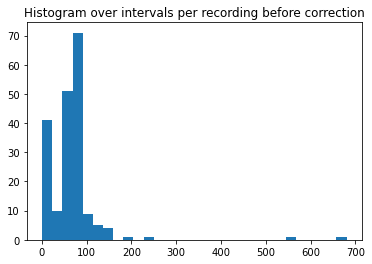

74.35384615384615
66.0


In [8]:
plt.hist(data_before, bins = 30)
plt.title("Histogram over intervals per recording before correction")
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_exp_before.jpg")
plt.show()
plt.close()


print(np.mean(data_before))
print(np.median(data_before))

It can be seen, that there is a few but very large samples (way larger than the mean).

The above plot is for the amount of 5 min. intervals per recording. A patient might have multiple recordings. Thus in the following the amount of 5 min. intervals per patient will be found:

In [9]:
patient_before = []

for value in patient_samples.values(): # go though the patient indicies
    vals = 0
    for i in value:
        vals += data_before[int(i)-1]
    
    patient_before.append(vals)

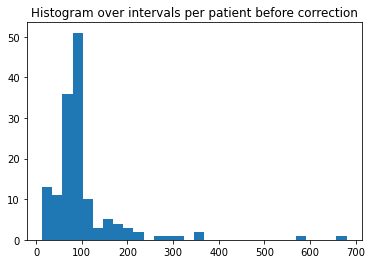

99.99310344827586
88.0


In [10]:
plt.hist(patient_before, bins = 30)
plt.title("Histogram over intervals per patient before correction")
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_patient_before.jpg")
plt.show()
plt.close()

print(np.mean(patient_before))
print(np.median(patient_before))

It can be seen from the histogram, that a few patients constitute with a lot of the 5 min. intervals in the data. Let's investigate how much data the top 25% of patients constitute with.

In [11]:
sorted_patient_before = sorted(patient_before, reverse=True)
print("Total number of patients:", len(patient_before))
print("25% of patients amounts to:", int(0.25*len(patient_before)))
print("The top 25% of patients constitute with:",
      sum(sorted_patient_before[:int(0.25*len(patient_before))])/sum(patient_before),
      "of the data")

Total number of patients: 145
25% of patients amounts to: 36
The top 25% of patients constitute with: 0.4845161735292089 of the data


This can also be seen in the plot of the Lorenz curve:

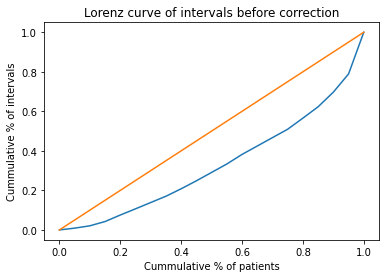

In [12]:
m = lorenz_curve(patient_before, "intervals before correction")

plt.savefig(f"C:/Users/Marc/Desktop/BP photos/Lorenz_before.jpg")
plt.show()
plt.close()


Thus it can be seen that a few patients constitute with a large amount of the data.

## Show the data with correction

To try and eliminate this inequality a few steps has to be made in the dataset:

In [13]:
import time


device = "cpu"
print(device)

# the load_whole_data laods a whole eeg-recording and targets into memory
trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", 
                            series_dict = 'train_series_length.pickle', 
                            ind = [i for i in range(1, 195 + 1)])


trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

data_after = []

nr_of_files_loaded = 0

batch_size = 1

start = time.time()

for file in trainloader:
    # instead of loading the total amount of 5 min. intervals possible
    # this dataloader tries to weight the recordings
    # thus short recordings will be represented as much as longer recordings
    loader2 = load_shuffle_5_min(file, device)
    loader2 = torch.utils.data.DataLoader(loader2,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)
    nr_of_files_loaded += 1
    j = 0
    for i in loader2:
        j += 1
    data_after.append(j) # append the amount of series loaded 

print("time:", time.time()-start)
    
print("Number of files loaded in total:", nr_of_files_loaded)


cpu
time: 13.104983806610107
Number of files loaded in total: 195


This data can now be plotted with a histogram:

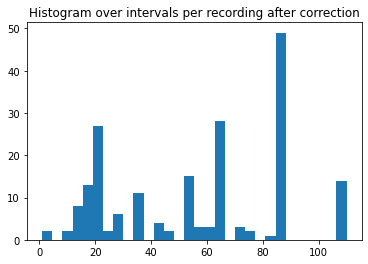

57.13333333333333
60.0


In [14]:
plt.title("Histogram over intervals per recording after correction")
plt.hist(data_after, bins = 30)
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_exp_after.jpg")
plt.show()
plt.close()

print(np.mean(data_after))
print(np.median(data_after))

Now it can be seen, that there are no longer any extreme cases.

The amount of 5 min. intevals per patient will be found:

In [15]:
patient_after = []

for value in patient_samples.values():
    vals = 0
    for i in value:
        vals += data_after[int(i)-1]
    
    patient_after.append(vals)

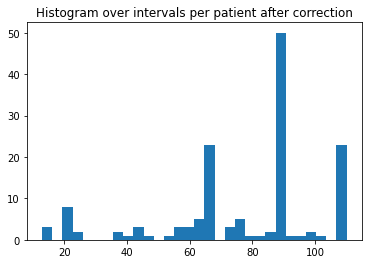

76.8344827586207
88.0


In [16]:
plt.title("Histogram over intervals per patient after correction")
plt.hist(patient_after, bins = 30)
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_patient_after.jpg")
plt.show()
plt.close()



print(np.mean(patient_after))
print(np.median(patient_after))

This again show, that a more fair distribution has been achived.

After the correction the amount of data that the top 25% of patients constitute with is:

In [17]:
sorted_patient_after = sorted(patient_after, reverse=True)
print("Total number of patients:", len(patient_after))
print("25% of patients amounts to:", int(0.25*len(patient_after)))
print("The top 25% of patients constitute with:",
      sum(sorted_patient_after[:int(0.25*len(patient_after))])/sum(patient_after),
      "of the data")

Total number of patients: 145
25% of patients amounts to: 36
The top 25% of patients constitute with: 0.33318373575083027 of the data


This more fair distribution can also be seen in the following Lorenz curve:

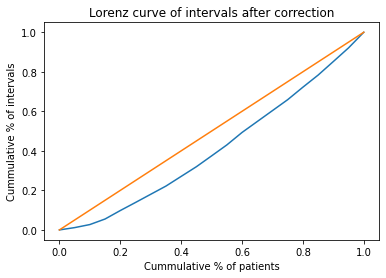

In [18]:
m = lorenz_curve(patient_after, "intervals after correction")

plt.savefig(f"C:/Users/Marc/Desktop/BP photos/Lorenz_after.jpg")
plt.show()
plt.close()

## Show the data with extreme correction

In [19]:
import time


device = "cpu"
print(device)

# the load_whole_data laods a whole eeg-recording and targets into memory
trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", 
                            series_dict = 'train_series_length.pickle', 
                            ind = [i for i in range(1, 195 + 1)])


trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

data_ex = []

nr_of_files_loaded = 0

batch_size = 1

start = time.time()

for file in trainloader:
    # the load_shuffle_5_min will now load the data with extreme correction
    loader2 = load_shuffle_5_min(file, device, ex = True)
    loader2 = torch.utils.data.DataLoader(loader2,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)
    nr_of_files_loaded += 1
    j = 0
    for i in loader2:
        j += 1
    
    data_ex.append(j)

print("time:", time.time()-start)
    
print("Number of files loaded in total:", nr_of_files_loaded)




cpu
time: 12.610124826431274
Number of files loaded in total: 195


Find how many intervals each patient consitute with:

In [20]:
patient_ex = []

for value in patient_samples.values():
    vals = 0
    for i in value:
        vals += data_ex[int(i)-1]
    
    patient_ex.append(vals)

The following shows that extreme equality has been achived:

In [21]:
sorted_patient_ex = sorted(patient_ex, reverse=True)
print("Total number of patients:", len(patient_ex))
print("25% of patients amounts to:", int(0.25*len(patient_ex)))
print("The top 25% of patients constitute with:",
      sum(sorted_patient_ex[:int(0.25*len(patient_ex))])/sum(patient_ex),
      "of the data")

Total number of patients: 145
25% of patients amounts to: 36
The top 25% of patients constitute with: 0.25192442267319803 of the data


Now the Lorenz plot can be created:

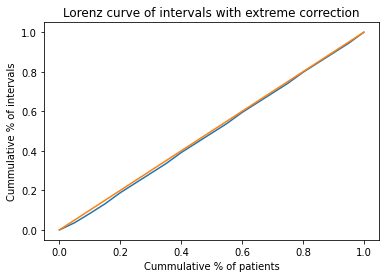

In [22]:
m = lorenz_curve(patient_ex, "intervals with extreme correction")

plt.savefig(f"C:/Users/Marc/Desktop/BP photos/Lorenz_low.jpg")
plt.show()
plt.close()

# Section 3: How the dataloading is equalized:

To make sure that data is distributed in the way that is intented, a pickle file with meta data of each recording is used. In the following code, this file will be looked at.
Files of this type is created by the script: "2 series_dict.py" found in the preprocess folder on git.

In [23]:
import pickle

# load the file:
with open('C:/Users/Marc/Desktop/model_data/train_model_data/train_series_length.pickle', 'rb') as handle:
    s_dict = pickle.load(handle)

Print the content for the first recording:

In [35]:
print(s_dict[1])

[290000, 1, 16, torch.Size([4, 290000])]


The first number is how many samples the patient delivered (in all of the recorded eeg-sessions).  
The second number is how many different times the patient has been recorded.  
The third number is how many intervals should be sampled from the recording in total. If a patient has a short recording, this will not be over sampled.  
The fourth value return the size of the given recording: (number of usefull channels, the length of the channels).

In [25]:
new_p = list(i for i in np.array(list(s_dict.values()))[...,2])

patient_after = []

for value in patient_samples.values():
    vals = 0
    for i in value:
        vals += new_p[int(i)-1]
    
    patient_after.append(vals)

C:\Users\Marc\AppData\Local\Temp\ipykernel_32388\2994339141.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_p = list(i for i in np.array(list(s_dict.values()))[...,2])


The following is the histogram and lorenz curve achived earlier

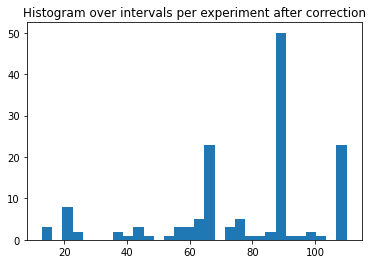

76.8344827586207
88.0


In [26]:
plt.title("Histogram over intervals per experiment after correction")
plt.hist(patient_after, bins = 30)
plt.show()

print(np.mean(patient_after))
print(np.median(patient_after))

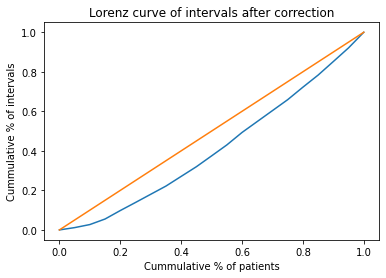

In [41]:
m = lorenz_curve(patient_after, "intervals after correction")

#plt.savefig(f"C:/Users/Marc/Desktop/BP photos/Lorenz_after.jpg")
plt.show()
#plt.close()